In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Concatenate, AveragePooling2D, Input
from keras.models import Model
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, save_model

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  
Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)
data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>
[125, 1243, 1293, 807, 1126, 1085, 226, 825, 813, 849, 1155, 749, 1204, 1235, 452, 354, 228, 632, 687, 109, 198, 162, 217, 276, 151, 830, 363, 133, 303, 156, 262, 457, 133, 373, 234, 697, 216, 115, 1168, 167, 191, 131, 141]


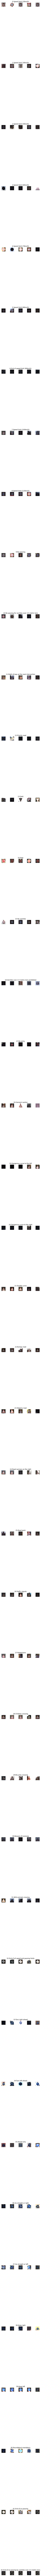

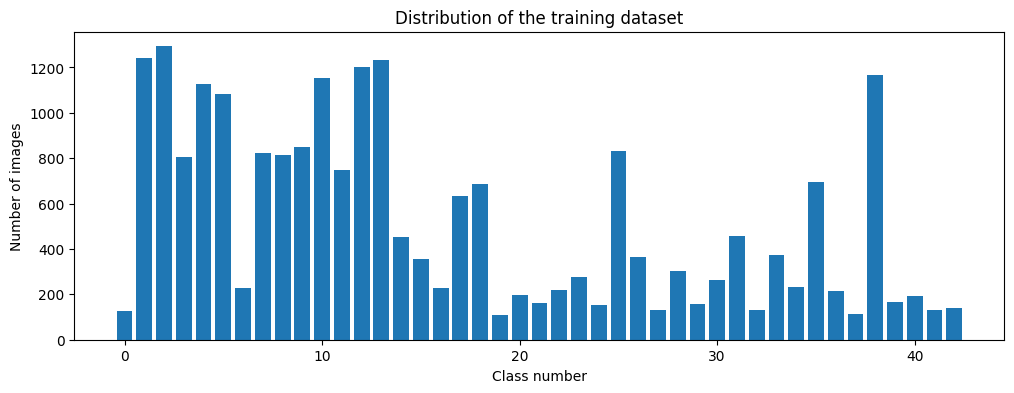

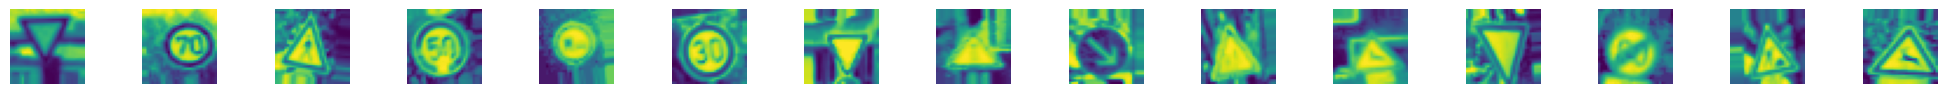

In [4]:
path = "myData"  # folder with all the class folders
labelFile = "labels.csv"  # file with all names of classes
imageDimensions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID


print("Data Shapes")
print("Train", end="")
print(X_train.shape, y_train.shape)
print("Validation", end="")
print(X_validation.shape, y_validation.shape)
print("Test", end="")
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[
    0]), "The number of images in not equal to the number of labels in training set"
assert (X_validation.shape[0] == y_validation.shape[
    0]), "The number of images in not equal to the number of labels in validation set"
assert (X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of labels in test set"
assert (X_train.shape[1:] == imageDimensions), " The dimensions of the Training images are wrong "
assert (X_validation.shape[1:] == imageDimensions), " The dimensions of the Validation images are wrong "
assert (X_test.shape[1:] == imageDimensions), " The dimensions of the Test images are wrong"

data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img


X_train = np.array(list(map(preprocessing, X_train)))  # TO ITERATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

# TO SHOW AUGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimensions[0], imageDimensions[1]))
    axs[i].axis('off')
plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             4160      ['max_pooling2d[0][0]']   

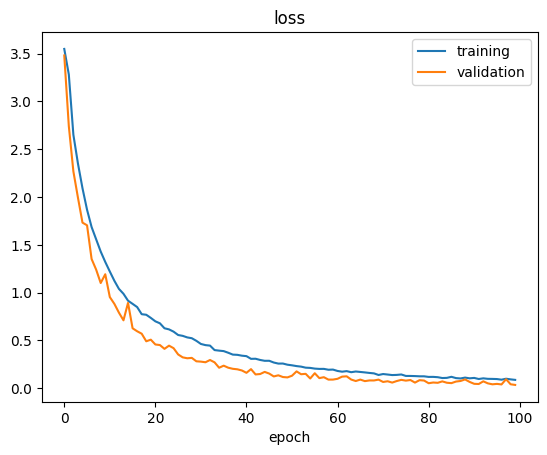

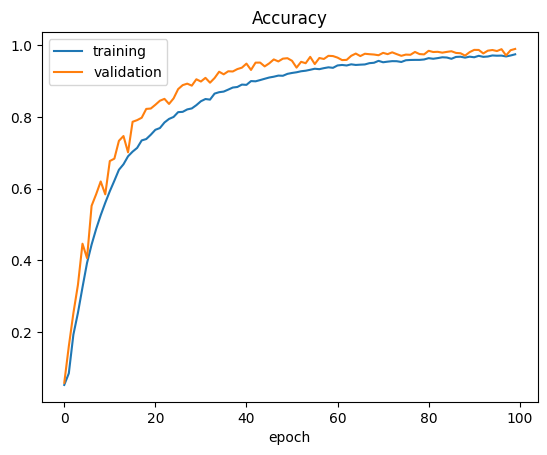

Test Score: 0.03435887396335602
Test Accuracy: 0.9908046126365662


<ipython-input-5-99aaf6b2fcf3>:110: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'model_trained.h5')


In [5]:
##inception v1
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def myModel():
    input_img = Input(shape=(imageDimensions[0], imageDimensions[1], 1))

    # Convolutional layer 1
    conv1_7x7 = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_img)
    pool1_3x3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1_7x7)

    # Convolutional layer 2
    conv2_3x3_reduce = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(pool1_3x3)
    conv2_3x3 = Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu')(conv2_3x3_reduce)
    pool2_3x3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2_3x3)

    # Convolutional layer 3
    conv3_3x3_reduce = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(pool2_3x3)
    conv3_3x3 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(conv3_3x3_reduce)
    pool3_3x3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv3_3x3)

    # Add another convolutional layer
    conv4_3x3_reduce = Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(pool3_3x3)
    conv4_3x3 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')(conv4_3x3_reduce)
    pool4_3x3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv4_3x3)

    # Inception module 1
    inception_3a_1x1 = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(pool4_3x3)
    inception_3a_3x3_reduce = Conv2D(96, kernel_size=(1, 1), padding='same', activation='relu')(pool4_3x3)
    inception_3a_3x3 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(inception_3a_3x3_reduce)
    inception_3a_5x5_reduce = Conv2D(16, kernel_size=(1, 1), padding='same', activation='relu')(pool4_3x3)
    inception_3a_5x5 = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(inception_3a_5x5_reduce)
    inception_3a_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(pool4_3x3)
    inception_3a_pool_proj = Conv2D(32, kernel_size=(1, 1), padding='same', activation='relu')(inception_3a_pool)
    inception_3a_output = Concatenate(axis=3)([inception_3a_1x1, inception_3a_3x3, inception_3a_5x5, inception_3a_pool_proj])

    # Inception module 2
    inception_3b_1x1 = Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(inception_3a_output)
    inception_3b_3x3_reduce = Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(inception_3a_output)
    inception_3b_3x3 = Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu')(inception_3b_3x3_reduce)
    inception_3b_5x5_reduce = Conv2D(32, kernel_size=(1, 1), padding='same', activation='relu')(inception_3a_output)
    inception_3b_5x5 = Conv2D(96, kernel_size=(5, 5), padding='same', activation='relu')(inception_3b_5x5_reduce)
    inception_3b_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inception_3a_output)
    inception_3b_pool_proj = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(inception_3b_pool)
    inception_3b_output = Concatenate(axis=3)([inception_3b_1x1, inception_3b_3x3, inception_3b_5x5, inception_3b_pool_proj])

    # Inception module 3
    inception_3c_1x1 = Conv2D(192, kernel_size=(1, 1), padding='same', activation='relu')(inception_3b_output)
    inception_3c_3x3_reduce = Conv2D(96, kernel_size=(1, 1), padding='same', activation='relu')(inception_3b_output)
    inception_3c_3x3 = Conv2D(208, kernel_size=(3, 3), padding='same', activation='relu')(inception_3c_3x3_reduce)
    inception_3c_5x5_reduce = Conv2D(16, kernel_size=(1, 1), padding='same', activation='relu')(inception_3b_output)
    inception_3c_5x5 = Conv2D(48, kernel_size=(5, 5), padding='same', activation='relu')(inception_3c_5x5_reduce)
    inception_3c_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inception_3b_output)
    inception_3c_pool_proj = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(inception_3c_pool)
    inception_3c_output = Concatenate(axis=3)([inception_3c_1x1, inception_3c_3x3, inception_3c_5x5, inception_3c_pool_proj])

    # Add another inception module
    inception_4a_1x1 = Conv2D(256, kernel_size=(1, 1), padding='same', activation='relu')(inception_3c_output)
    inception_4a_3x3_reduce = Conv2D(192, kernel_size=(1, 1), padding='same', activation='relu')(inception_3c_output)
    inception_4a_3x3 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(inception_4a_3x3_reduce)
    inception_4a_5x5_reduce = Conv2D(32, kernel_size=(1, 1), padding='same', activation='relu')(inception_3c_output)
    inception_4a_5x5 = Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu')(inception_4a_5x5_reduce)
    inception_4a_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inception_3c_output)
    inception_4a_pool_proj = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(inception_4a_pool)
    inception_4a_output = Concatenate(axis=3)([inception_4a_1x1, inception_4a_3x3, inception_4a_5x5, inception_4a_pool_proj])

    # Final layers
    global_pool = GlobalAveragePooling2D()(inception_4a_output)
    dropout = Dropout(0.6)(global_pool)
    flatten = Flatten()(dropout)
    output = Dense(noOfClasses, activation='softmax')(flatten)

    model = Model(inputs=input_img, outputs=output)
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.000075), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())
steps_per_epoch_val = 650
batch_size_val = 32
epochs_val = 100

# Train the model
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=steps_per_epoch_val,
                    epochs=epochs_val,
                    validation_data=(X_validation, y_validation),
                    shuffle=True)

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# STORE THE MODEL
save_model(model, 'model_trained.h5')

##a128,0.001,26,0.91
##a128,0.0001,..,0.92
##a64,0.0001,17,0.94
##a64,1700,200,0.0001,0.961
##a32,2000,200,0.0001,0.964
##a32,3000,30,0.001,0.79
##a32,3000,50,0.001,0.81
##a32,3000,30,0.0001,0.87(0.6)
##a32,3000,30,0.0001,0.89(0.5)
##a32,3000,200,0.0001,0.966(0.6)
##a32,3000,200,0.0001,0.964(0.5)
##b32,3000,30,0.0001,0.798
##b32,3000,30,0.001,**
##b32,4000,30,0.0001,0.81
##b32,5000,50,0.0001,**
##a32,3000,200,0.0001,0.963(0.6)
##b32,4000,200,0.00003,0.88
##a32,4000,200,0.00001,**
##a32,4000,100,0.00001,0.93
##a32,4000,100,0.00003,0.93
##a32,4000,100,0.00005,0.97
##a32,650,100,0.00008,**
##a32,650,100,0.00007,0.98
##a32,650,100,0.000075,0.9907